In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_error

warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/foot_traffic.csv")

In [3]:
data.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


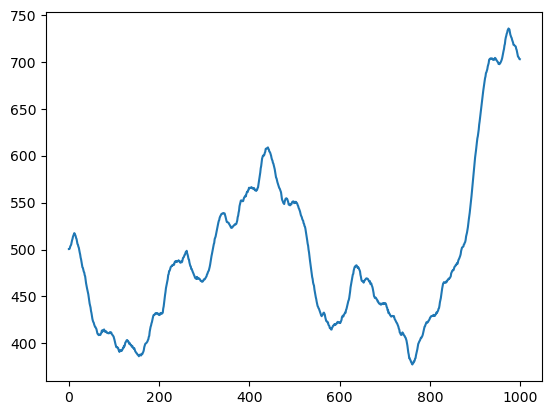

In [4]:
plt.plot(data['foot_traffic'])

In [5]:
adtest=adfuller(data['foot_traffic'])
print('adtest value ',adtest[0])
print('p value ',adtest[1])

adtest value  -1.1758885999240747
p value  0.683880891789619


In [6]:
data_diff=np.diff(data['foot_traffic'],n=1)

In [7]:
adtest=adfuller(data_diff)
print('adtest value ',adtest[0])
print('p value ',adtest[1])

adtest value  -5.268231347422044
p value  6.369317654781239e-06


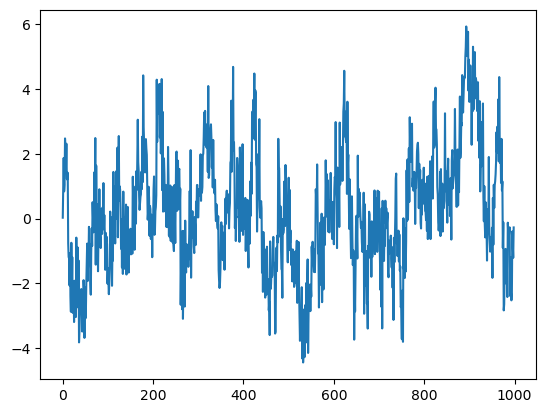

In [8]:
plt.plot(data_diff)

# Checking the mean for the diff and non-diff data

In [9]:
len(data_diff)

999

In [10]:
def clauclate_mean(df):
    means=[]
    for i in range(len(df)):
        means.append(np.mean(df[:i]))
    return means

In [11]:
m1=clauclate_mean(data)
m2=clauclate_mean(data_diff)

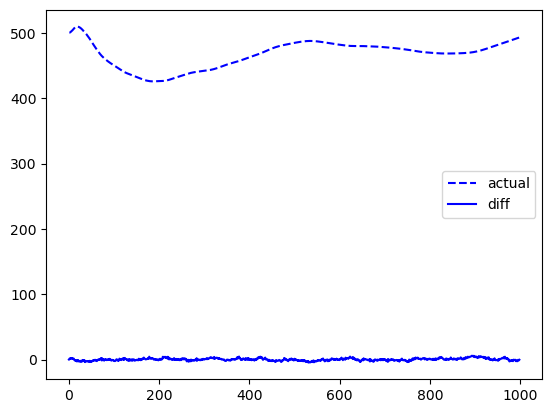

In [12]:
plt.plot(m1,'b--',label='actual')
plt.plot(data_diff,'b-',label='diff')
plt.legend()

# Plotting PACF and ACF for both the diff and non diff data

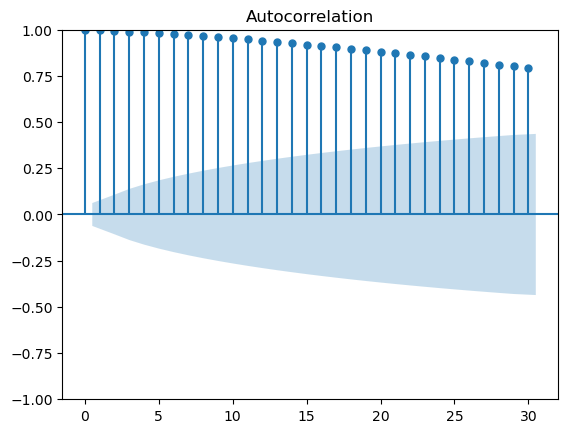

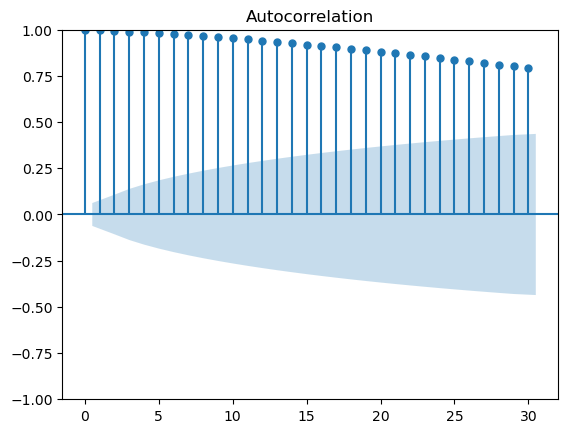

In [13]:
plot_acf(data)

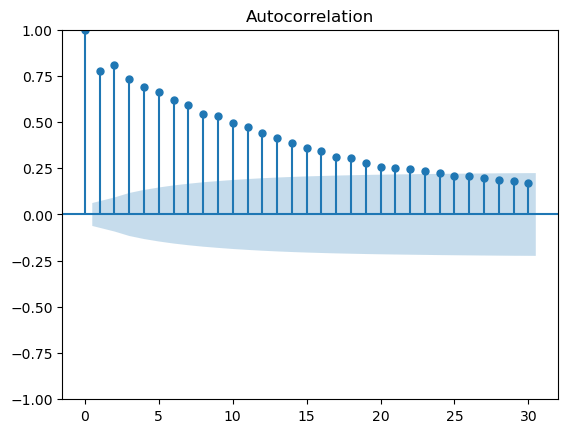

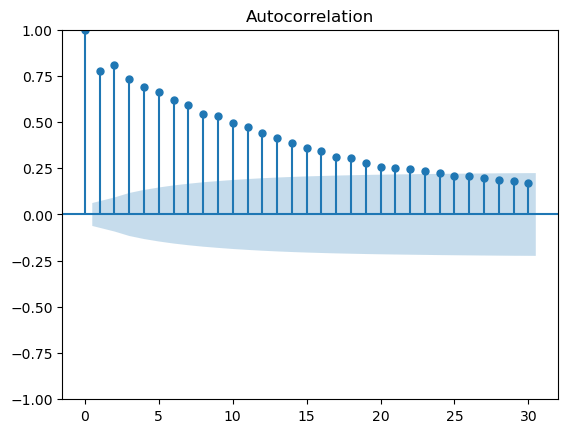

In [14]:
plot_acf(data_diff)

here in the above graph we can notice that there is a gradula decrease in the ACF plots so we can clearly notice that there is the Auto regressive factor in the data since AR model is depende on teh all the previous data we cannot know which is the most sigfint p value becase ACF cannot eliminate the the influnce of the intermidate lags

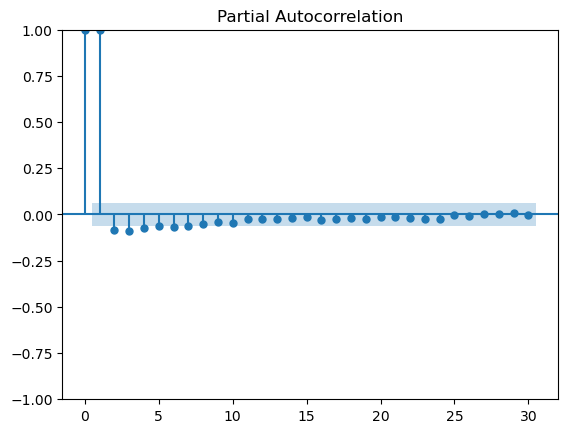

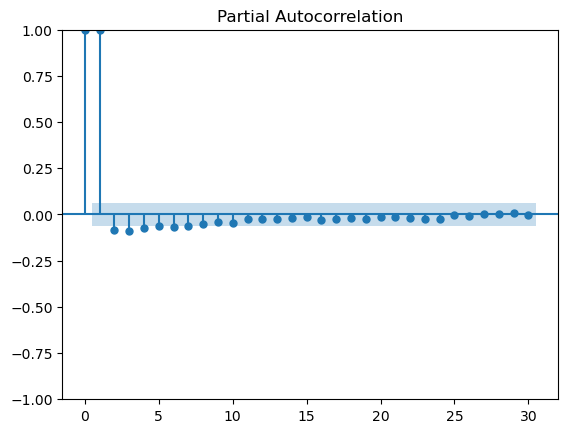

In [15]:
plot_pacf(data)

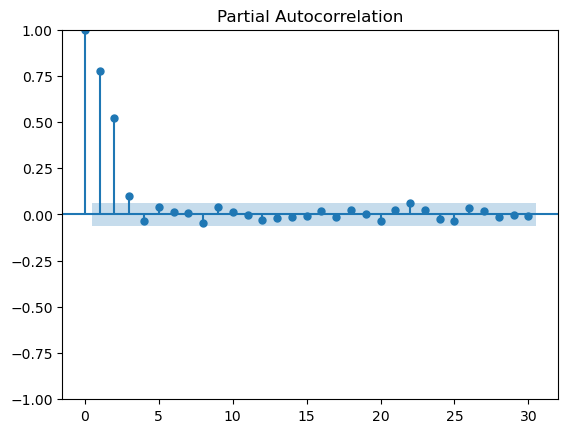

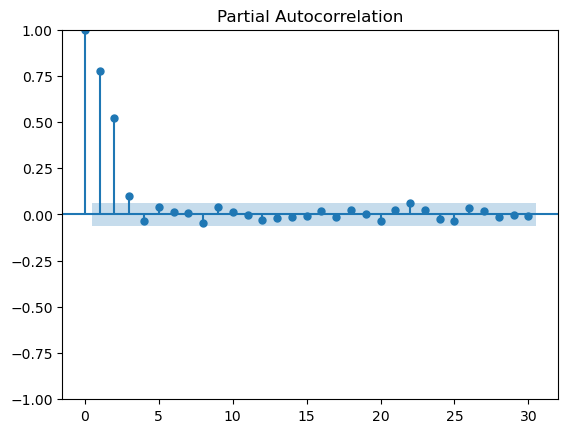

In [16]:
plot_pacf(data_diff)

from teh above graph we can say that there is the corelation till lag 3 of the PACF so we can say that p is 3

In [17]:
train=data_diff[:-52]
test=data_diff[-52:]

In [21]:
print(len(train),len(test))

947 52


In [19]:
def forecast(train_len,test_len,window,df,type_):
    
    total_len=train_len+test_len
    
    if type_=='mean':
        value=[]
        for i in range(train_len,total_len,window):
            mean_value=np.mean(df[:i].values)
            value.extend(mean_value for _ in range(window))
        return value
    elif type_=='last':
        value=[]
        for i in range(train_len,total_len,window):
            mean_value=df[:i].iloc[-1].values[0]
            value.extend(mean_value for _ in range(window))
        return value
    else:
        value=[]
        for i in range(train_len,total_len,window):
            model=SARIMAX(endog=df[:i],order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            value.extend(oos_pred)
        return value


In [22]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = forecast(TRAIN_LEN, HORIZON, WINDOW,pd.DataFrame({'dff':data_diff}) ,'mean')
pred_last_value = forecast(TRAIN_LEN, HORIZON, WINDOW,pd.DataFrame({'dff':data_diff})  ,'last')
pred_AR = forecast(TRAIN_LEN, HORIZON, WINDOW,pd.DataFrame({'dff':data_diff} ) ,'ar')

test=pd.DataFrame({'actual_test':list(test)})

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,actual_test,pred_mean,pred_last_value,pred_AR
0,-0.776601,0.213270,-1.021893,-0.719714
1,-0.574631,0.213270,-1.021893,-0.796525
2,-0.890697,0.211397,-0.574631,-0.664738
3,-0.283552,0.211397,-0.574631,-0.569897
4,-1.830685,0.209717,-0.283552,-0.579279


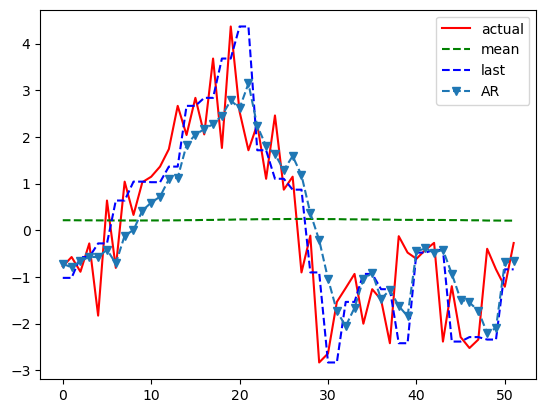

In [25]:
plt.plot(test['actual_test'],'r-',label='actual')
plt.plot(test['pred_mean'],'g--',label='mean')
plt.plot(test['pred_last_value'],'b--',label='last')
plt.plot(test['pred_AR'],'v--',label='AR')

plt.legend()

In [28]:
mse_mean = mean_squared_error(test['actual_test'], test['pred_mean'])
mse_last = mean_squared_error(test['actual_test'], test['pred_last_value'])
mse_AR = mean_squared_error(test['actual_test'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1102547192143772 1.1635356232421425 0.9685000987976042


In [38]:
data['pred_foot_traffic'] = pd.Series()
data['pred_foot_traffic'][948:] = data['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()


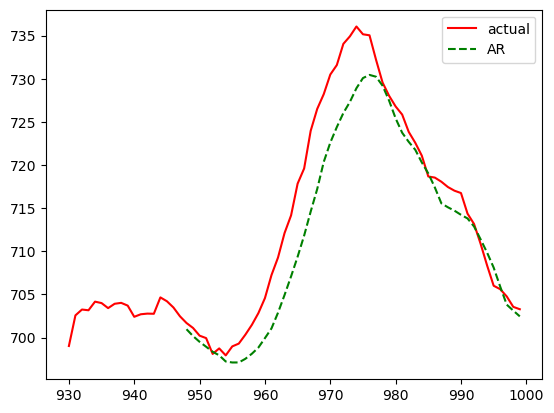

In [41]:
plt.plot(data['foot_traffic'][930:],'r-',label='actual')
plt.plot(data['pred_foot_traffic'][930:],'g--',label='AR')

plt.legend()

In [44]:
mean_absolute_error(data['foot_traffic'][948:],data['pred_foot_traffic'][948:])

3.248027989827716